
<h1><center> FETCH DATA ANALYST TAKE HOME PROJECT</center></h1>

The following analysis is for Fetch Take Home project. The assignment has three parts with two questions in the first part, three questions in the second part, and a written communication in the third part. The files used in this assignment are Violets are blue. <span style='color:green'>USER_TAKEHOME.csv</span>, <span style='color:green'>PRODUCTS_TAKEHOME.csv</span>, and <span style='color:green'>TRANSACTION_TAKEHOME.csv</span>. The Transaction dataset contains data from June 2024 to September 2024.

Tools used for this project include Excel/ Google Sheets, Python, and SQL.

### <center> Summary of findings (python)

**Question 1:** *Are there any data quality issues present?*

Yes, all three tables contain data quality issues, although one table has more issues than the other two. The data quality issues found include: inconsistency in categories within variables, mispelling, different types of data within a variable, duplicate rows, missing data, and incorret data types. A summary of performed checks and findings is listed below:

**USER table**:
    
* inconsistency in categories: *Non-Binary* vs *non_binary*, *My gender isn't listed* vs *not_listed*, and *Prefer not to say* vs *prefer_not_to_say*
* 5 variables have missing data e.g., contain NaNs/Null values.
* no duplicates rows.
* Checked that all state acronyms corresponded to an actual state. Note that *PR* and *DC* are listed in the states column.

**PRODUCTS table**:
* 4 variables have missing data e.g., contain NaNs/Null values.
* typos: Accesories, "Alchoholic" 
* A total of 57 duplicate rows were found.

**TRANSACTION table**:
* 2 variables have missing data e.g., contain NaNs/Null values.
* found capitalization inconsistency e.g., "TINKER COMMISsARY"
* ``FINAL_QUANTITY`` variable data issues:
    * contains the string *zero* instead of 0.
    * has non-integer values for quantities (e.g., 1.23), which does not make sense.
* A total of 171 duplicate rows were found.

**Question 2:** *Are there any fields that are challenging to understand?*

The <span style='color:green'>TRANSACTION</span> table contains non-integer values in a ``FINAL_QUANTITY`` variable. Moreover, there are two rows per transaction with each ``FINAL_QUANTITY`` and ``FINAL_PRICE`` variable combination, made this table tricky to understand. We will partially clean this table in python and move the rest of the analysis and cleaning to SQL.

In the next steps we will explore and clean the data in order to determine the impact it may have in the questions we are trying to answer. In **Data Cleaning Part 1** we remove category Inconsistencies, re-format date variables, remove duplicate rows, and create new variables needed for part 2 of the assignment. In **Data Cleaning Part 2** we explore missing (null) values and check for other data Inconsistencies. We will also make note of any interesting observations we find along the way.

## Section 1: Data Cleaning Part 1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm # for qqplot
from datetime import datetime # to calculate age in years.

### Section 1.1: User-defined functions.
Due to the repetitive nature of data exploration for each dataset, we create the following functions that will both minimize code and improve redability for analysis.

In [2]:
##################################################################################
# Returns a dictionary to easily change dataframe column names to lowercase.
##################################################################################
def col_names_to_lower(dataframe):
    col_names = list(dataframe.columns)
    return dict(list(zip(col_names, list(map(lambda name: name.lower(), col_names)))))

##################################################################################
# Checks whether a dataframe has duplicate rows. Returns the deduped dataframe.
##################################################################################
def check_for_duplicates(dataframe):
    if True in set(dataframe.duplicated()):
        n_before_dedup = dataframe.shape[0]
        dataframe.drop_duplicates(inplace = True)
        n_after_dedup  = dataframe.shape[0]
        print(f'A total of {n_before_dedup - n_after_dedup} duplicate rows have been dropped.')
    else:
        print('This table has 0 duplicate rows')
    return dataframe

### Section 1.2: Cleaning the USER_TAKEHOME dataset

In [3]:
df_user = pd.read_csv('USER_TAKEHOME.csv')
df_user.head(3)

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female


In [4]:
df_user['GENDER'].value_counts() # check for category consistency in the gender variable.

GENDER
female                    64240
male                      25829
transgender                1772
prefer_not_to_say          1350
non_binary                  473
unknown                     196
not_listed                  180
Non-Binary                   34
not_specified                28
My gender isn't listed        5
Prefer not to say             1
Name: count, dtype: int64

After close inspection, we see that there are inconsistent values in the column ``GENDER``. For example, the following values need to be standardized for consistency:
* *Non-Binary* to *non_binary*
* *My gender isn't listed* to *not_listed*
* *Prefer not to say* to *prefer_not_to_say*

In [5]:
# clean the category incosistency within the GENDER variable.
df_user['GENDER'] = df_user['GENDER'].replace('Non-Binary', 'non_binary').replace("My gender isn't listed", 'not_listed').replace('Prefer not to say', 'prefer_not_to_say')

# check that the changes went through
df_user['GENDER'].value_counts()

GENDER
female               64240
male                 25829
transgender           1772
prefer_not_to_say     1351
non_binary             507
unknown                196
not_listed             185
not_specified           28
Name: count, dtype: int64

Next, we check for duplicates. Afterwards, we re-format the ``CREATED_DATE`` and ``BIRTH_DATE`` variables for easy date-consumption, then create a ``user_age``, ``account_age_months``, and ``generation`` variable. These last 3 variables are needed for the second part of the assignment.

In [6]:
df_user = check_for_duplicates(df_user) # check for duplicate rows and deduplicate if necessary.

This table has 0 duplicate rows


In [7]:
df_user['birth_date']   = pd.to_datetime(df_user['BIRTH_DATE']  ).dt.strftime('%Y-%m-%d')
df_user['created_date'] = pd.to_datetime(df_user['CREATED_DATE']).dt.strftime('%Y-%m-%d')
df_user.head(3)

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER,birth_date,created_date
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female,2000-08-11,2020-06-24
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female,2001-09-24,2021-01-03
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female,1994-10-28,2023-05-31


In [8]:
df_user.drop(['CREATED_DATE','BIRTH_DATE'], axis = 1, inplace = True) # drop columns from the dataframe
df_user.rename(columns = col_names_to_lower(df_user), inplace = True) # rename columns to lowercase.
df_user.head(3)

,id,state,language,gender,birth_date,created_date
0,5ef3b4f17053ab141787697d,CA,es-419,female,2000-08-11,2020-06-24
1,5ff220d383fcfc12622b96bc,PA,en,female,2001-09-24,2021-01-03
2,6477950aa55bb77a0e27ee10,FL,es-419,female,1994-10-28,2023-05-31


In [9]:
# obtain the age of each user.
todays_date = pd.to_datetime(datetime.today().strftime('%Y-%m-%d')) # get today's date in the format YYYY-MM-DD
df_user['birth_date']   = pd.to_datetime(df_user['birth_date'])
df_user['created_date'] = pd.to_datetime(df_user['created_date'])
df_user['user_age'] = df_user['birth_date'].apply(lambda x: todays_date.year - x.year - ((todays_date.month, todays_date.day) < (x.month, x.day)) )

# obtain the age of each account (in months).
df_user['accnt_age_months'] = (todays_date.to_period('M') - df_user['created_date'].dt.to_period('M')).apply(lambda x: x.n)

Finally, we create the variable to categorize each user.

In [10]:
# used "https://en.wikipedia.org/wiki/Generation" to define generations.
group_names = ['Lost Gen', 'Greatest Gen', 'Silent Gen','Baby Boomers', 'Gen X', 'Milennials', 'Gen Z', 'Gen Alpha']
evaluation_bins = [1883, 1900, 1927, 1945, 1964, 1980, 1996, 2010, 2025]
df_user['generation'] = pd.cut(x      = df_user['birth_date'].dt.year.convert_dtypes(), 
                               bins   = evaluation_bins, 
                               labels = group_names)

In [11]:
# save the clean data into a csv file.
df_user.to_csv('user_sql.csv')
df_user.head(3)

,id,state,language,gender,birth_date,created_date,user_age,accnt_age_months,generation
0,5ef3b4f17053ab141787697d,CA,es-419,female,2000-08-11,2020-06-24,24.0,56,Gen Z
1,5ff220d383fcfc12622b96bc,PA,en,female,2001-09-24,2021-01-03,23.0,49,Gen Z
2,6477950aa55bb77a0e27ee10,FL,es-419,female,1994-10-28,2023-05-31,30.0,21,Milennials


### Section 1.3: Cleaning the PRODUCTS_TAKEHOME dataset

In [12]:
df_products = pd.read_csv('PRODUCTS_TAKEHOME.csv', dtype={'BARCODE':np.object_}) # ensure that barcode is not read in scientific notation.
df_products.head(3)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,796494407820
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,023278011028
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,461817824225


Unlike the <span style='color:green'>USER</span> dataset, no consistency corrections seem to be necessary. However, it is worth noting that a SpellChecker revealed a few mispelled words. Further analysis will be needed to determine if these mispelling will cause any issues down the line; however, we assume that the impact is minimal or none due to its very low count and our target questions. Finally, this table contains duplicate rows.

In [13]:
df_products = check_for_duplicates(df_products) # check for duplicate rows and deduplicate if necessary

A total of 57 duplicate rows have been dropped.


In [14]:
# change all column names to lower case.
df_products.rename(columns = col_names_to_lower(df_products), inplace = True)

# save file to process in SQL.
df_products.to_csv('products_sql.csv')
df_products.head(3)

,category_1,category_2,category_3,category_4,manufacturer,brand,barcode
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,796494407820
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,023278011028
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,461817824225


### Section 1.4: Cleaning the TRANSACTION_TAKEHOME dataset

In [15]:
df_transaction = pd.read_csv('TRANSACTION_TAKEHOME.csv', dtype={'BARCODE':np.object_}) # ensure that barcode is not read in scientific notation.
df_transaction.head(3)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,015300014978,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,078742229751,1.00,


We immediately notice the the string *zero* is in the ``FINAL_QUANTITY`` column and fix it. Afterwards, we re-format the ``SCAN_DATE`` variable.

In [16]:
df_transaction['FINAL_QUANTITY'] = df_transaction['FINAL_QUANTITY'].replace('zero', 0.00)

df_transaction['Scan_Date']  = pd.to_datetime(df_transaction['SCAN_DATE']).dt.strftime('%Y-%m-%d')
df_transaction.drop(['SCAN_DATE'], axis = 1, inplace=True) # drop columns from the dataframe

Next, we find a total of 171 duplicate rows.

In [17]:
df_transaction = check_for_duplicates(df_transaction) # check for duplicate rows and deduplicate if necessary

A total of 171 duplicate rows have been dropped.


Further analysis reveals that the ``FINAL_SALE`` variable contains empty strings. We fix this and make other datatype corrections.

In [18]:
df_transaction.rename(columns = col_names_to_lower(df_transaction), inplace = True) #make column names lowercase.

df_transaction['purchase_date']  = pd.to_datetime(df_transaction['purchase_date'])
df_transaction['scan_date']      = pd.to_datetime(df_transaction['scan_date'])

df_transaction['final_quantity'] = df_transaction['final_quantity'].astype('float') # this variable was imported as a string.

df_transaction['final_sale']     = df_transaction['final_sale'].replace(' ', np.NaN).astype('float') # remove empty strings, and make a number.

The <span style='color:green'>TRANSACTION</span> table has some confusing information in recards to the ``final_quantity`` and ``final_sale`` variable that will be investigated further when we move to SQL, which invovles 0's and NaNs.

In [19]:
# save semi-clean file to process in SQL
df_transaction.to_csv('transaction_sql.csv')
df_transaction.head(3)

,receipt_id,purchase_date,store_name,user_id,barcode,final_quantity,final_sale,scan_date
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,WALMART,63b73a7f3d310dceeabd4758,015300014978,1.0,NaN,2024-08-21
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,ALDI,62c08877baa38d1a1f6c211a,NaN,0.0,1.49,2024-07-20
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,WALMART,60842f207ac8b7729e472020,078742229751,1.0,NaN,2024-08-19


# Section 2: Data Cleaning Part 2: NaNs, Nulls, and other observations.

In [20]:
########################################################################################################
# This function will output a series containg the number of missing or null values for each column in  
# a dataframe. If flag = True, the function will printout counts and percents as text.
########################################################################################################
def missing_data_counts(dataframe, flag = False):
    missing_data = dataframe.isnull()
    n = dataframe.shape[0]
    percents, names = list(), list()
    
    for column in missing_data.columns.values.tolist():
        x = missing_data[column].value_counts()
        y = x.index
        count = x[True] if True in y else 0
        percents.append(count/n)
        names.append(y.name)
        
        if flag == True:
            print(f'The column {y.name.upper()} has {count} missing or null values. This represents {count*100/n:.2f}% of the column data.')
    return pd.Series(data = percents, index = names)
    

### Section 2.1: Missing data from the USER, PRODUCTS, and TRANSACTION tables.
In this part, we determine the percent distribution of missing values of each of the variables in each table. 

[Text(0.5, 14.722222222222216, 'TRANSACTION table')]

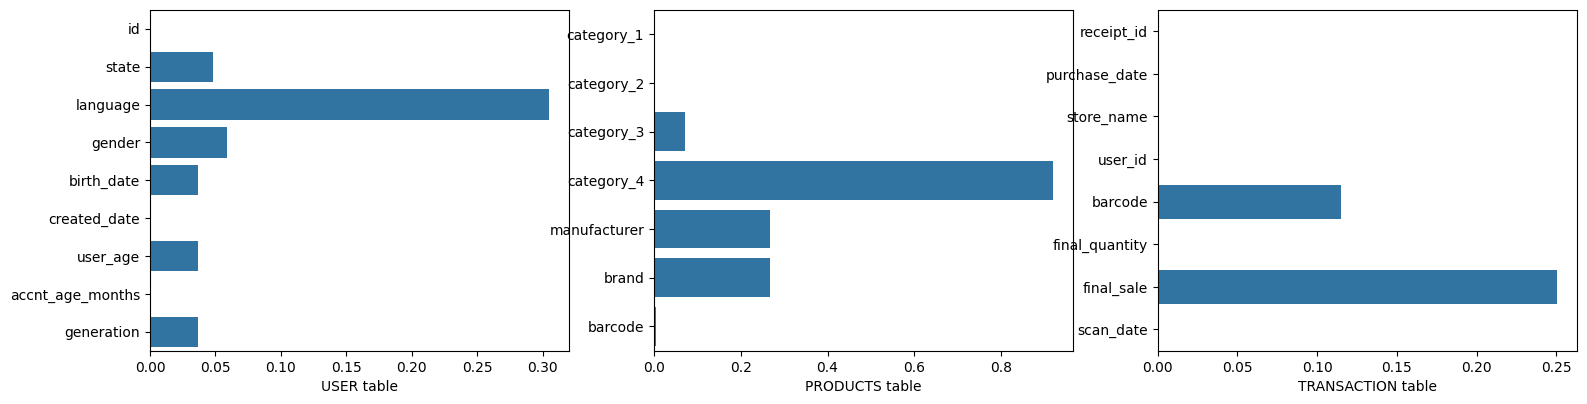

In [21]:
missing_user_data        = missing_data_counts(df_user)
missing_products_data    = missing_data_counts(df_products)
missing_transaction_data = missing_data_counts(df_transaction)

fig, axs = plt.subplots(ncols = 3, figsize = (15, 4))
fig.tight_layout(w_pad = 3.0)
sns.barplot(x  = missing_user_data,        
            y  = missing_user_data.index.to_list(), 
            ax = axs[0]).set(xlabel = 'USER table')
sns.barplot(x  = missing_products_data,    
            y  = missing_products_data.index.to_list(), 
            ax = axs[1]).set(xlabel = 'PRODUCTS table')
sns.barplot(x  = missing_transaction_data, 
            y  = missing_transaction_data.index.to_list(), 
            ax = axs[2]).set(xlabel = 'TRANSACTION table')

The above plots show that most variables in the <span style='color:green'>USER</span> table (100,000 records) have around 5% of missing data, except for ``language``, which is about 30% (note that ``user_age`` and ``generation`` are based off of ``birth_date``). The ``category_4`` variable in the <span style='color:green'>PRODUCTS</span> table (845,495 records) is missing over 90% of the data, while most other variables are less than 35%. Morevover, a variable that will be needed for our analysis, ``brand``, is missing about 25% of the data. Finally, ``barcode`` and ``final_sale`` are the only variable from the <span style='color:green'>TRANSACTION</span> table (49,829 records) that is missing data, accounting for about 12% and 25%, respectively. However, when we move to SQL we will demonstrate that those 25% from ``final_sale`` are redundant data.

### Section 2.2: Data Anomalies.

In this section we investigate variables in each of the datasets and check for anomalies.

**Age**: First, we look over the ``user_age`` variable. Here we see unusual values as low as 2 years of age and as high as 125 years (current world guinness record is 116 years of age). Older ages are possible and likely, but that cannot be said for a user that is 2 years of age. Fortunately, the number of these type of records are insignificant (there are 77 records below age 8 or above age 100) compared to the data size of about 96k records.

In [22]:
df_age_no_nulls = df_user['user_age'].dropna().astype('int')

print(df_age_no_nulls.describe())
print(f'\nA total of {len(df_age_no_nulls[(df_age_no_nulls < 8) | (df_age_no_nulls > 100)])} records fall below 8 years or above 100 years')

count    96325.000000
mean        39.996719
std         15.171717
min          2.000000
25%         27.000000
50%         39.000000
75%         50.000000
max        125.000000
Name: user_age, dtype: float64

A total of 77 records fall below 8 years or above 100 years


**scan date**: (see next section).

**final_quantity**: This variable has 49,829 values, of which 110 were found to have decimal values. Fortunately, this represents about 0.2% of the data and we suspect we can safely remove them. We will investigate further in SQL.

In [23]:
df_quantity = df_transaction['final_quantity']

# identify records with non-zero decimal part. We will use this indentifier later in SQL.
df_transaction['decimal_quantity'] = df_quantity - df_quantity.apply(lambda i: int(i)) > 0 

quantity_with_decimals = df_quantity[df_transaction['decimal_quantity']]
num_quantity_decimals = len(quantity_with_decimals)
pcnt_value = num_quantity_decimals*100/df_transaction['final_quantity'].size

print(f'### There are {num_quantity_decimals} quantity-values represented as a decimal.')
print(f'### This corresponds to about {pcnt_value:.2f}% of the column data.')
print('\n###Examples shown below')
quantity_with_decimals.head(3)

### There are 110 quantity-values represented as a decimal.
### This corresponds to about 0.22% of the column data.

###Examples shown below


1372    4.55
1420    2.83
1978    2.34
Name: final_quantity, dtype: float64

In [24]:
# save this new information.
df_transaction.to_csv('transaction_sql.csv')

### Section 3: Further observations

In [25]:
##################################################################################
# Plots the distribution of a series based on categorical variables.
##################################################################################
def drop_na_barplot(series_data, color = 'red', head = True, size = 5):
    series_no_nulls = series_data.dropna()
    df = series_no_nulls.value_counts()
    if head == False:
        (df/sum(df)).plot(kind = 'bar', color = color, figsize = (4,2))
    else:
        (df/sum(df)).head(size).plot(kind = 'bar', color = color, figsize = (4,2))
    return series_no_nulls

We now look at a few variables in our table and obtain some insights of the data.

**Age**: The age distribution shows that a large percent of our users are in their 20s and 40s. The data does not follow a normal distribution, but is large enough to make inferences.

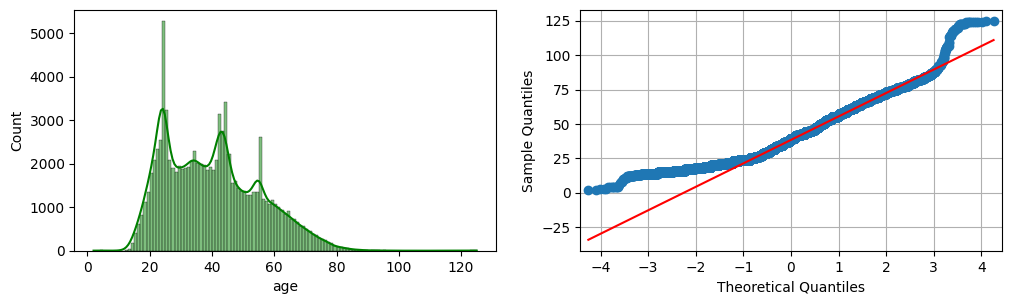

In [26]:
fig, axs = plt.subplots(ncols = 2, figsize = (10, 3))
fig.tight_layout(w_pad = 3.0)
sns.histplot(df_age_no_nulls, kde = True, color = 'green', ax = axs[0]).set(xlabel = 'age')
sm.qqplot(df_age_no_nulls, line = 'q', ax = axs[1])
plt.grid(True)

**gender**: Our analysis suggests that females account to close to 69% of users, while males are in the 28% range. The rest of the users account for less than 2% each.

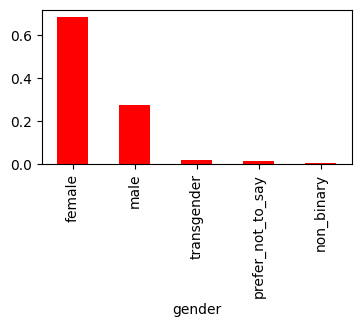

In [27]:
df_gender_no_nulls = drop_na_barplot(df_user['gender'])

if we consider both **age** and **gender**, a large proportion of users are in their 20's and 40's, for all groups.

<Figure size 200x100 with 0 Axes>

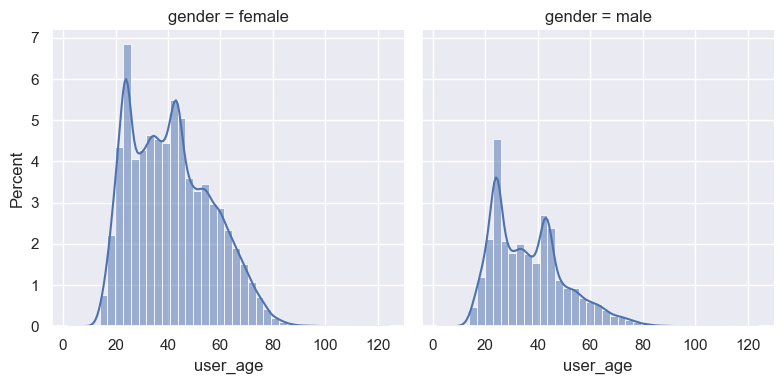

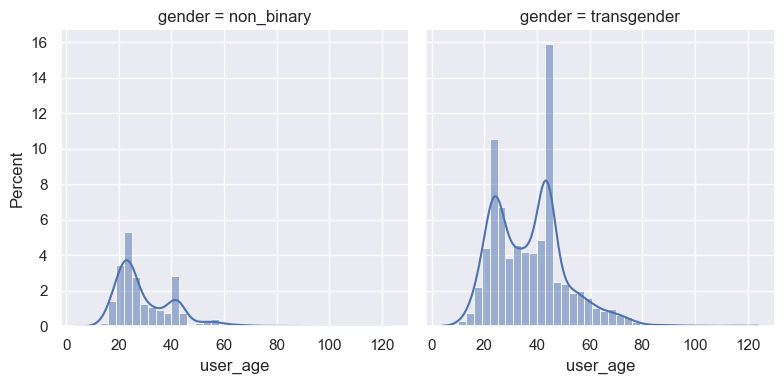

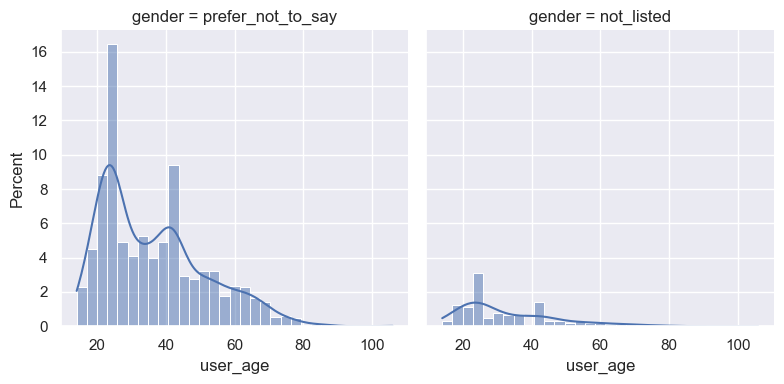

In [28]:
df_gender_age = df_user[['gender','user_age']].dropna()

sns.set_theme(style="darkgrid")
plt.figure(figsize=(2, 1))

sns.displot(data = df_gender_age.query("gender == 'female' | gender == 'male'"), 
            x='user_age', col='gender', 
            binwidth=3, height = 4, facet_kws=dict(margin_titles = True), stat = 'percent', kde = True)
sns.displot(data = df_gender_age.query("gender == 'transgender' | gender == 'non_binary'"), 
            x='user_age', col='gender', 
            binwidth=3, height = 4, facet_kws=dict(margin_titles = True), stat = 'percent', kde = True)
sns.displot(data = df_gender_age.query("gender == 'prefer_not_to_say' | gender == 'not_listed'"), 
            x='user_age', col='gender', 
            binwidth=3, height = 4, facet_kws=dict(margin_titles = True), stat = 'percent', kde = True)

**state**: Four states take over 30% of our users, and over half of our users come from 9 out of the 50 states.

In [29]:
user_state = df_user['state'].dropna().value_counts()

# create a table showing the cummulative sum of users per state.
y = np.round(user_state*100/user_state.sum(),2)
y.name = 'percent'
y_sum = y.cumsum()
y_sum.name = 'cumm_sum'
user_demographics = pd.concat([y,y_sum], axis = 1)
user_demographics.head(5)

,percent,cumm_sum
state,,
TX,9.48,9.48
FL,9.37,18.85
CA,9.02,27.87
NY,5.99,33.86
IL,3.99,37.85


 **brands:** In terms of brands found in our dataset close to 3.4% correspond to REM BRAND, 2.7% to BRAND UNKWN, 2.1% to PRIVATE LABEL while all others are less than 1%. It's worth mentioning that we have a high number of missing data in this variable.

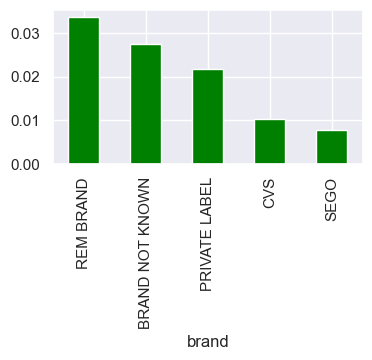

In [30]:
df_products_no_nulls = drop_na_barplot(df_products['brand'], color = 'green')

**purchase_date**: For the given time interval, purchases peaked in July (37% of sales) and declined all the way to September, the latter being the lowest of the four months, with only about 6% of the sales.

<Axes: xlabel='purchase_year_month'>

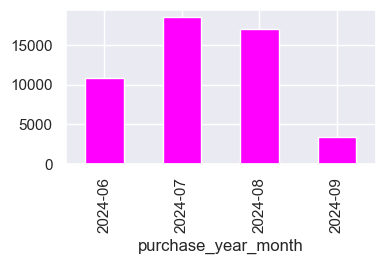

In [31]:
z = pd.to_datetime(df_transaction['purchase_date'].dropna())
df_pdate = pd.DataFrame(zip(z, z.dt.to_period('M')), columns = ['purchase_date', 'purchase_year_month'])
df_pdate['purchase_year_month'].value_counts().sort_index().plot(kind = 'bar', color = 'magenta', figsize = (4,2))

**scan date**: One observation of interested is the number of days from the time of purchase to the time a product is scanned. Summary statistics reveals that over 60% of products are scanned within 2 days of the purchased date. We did find an anomaly of scanned products before being purchased, which we should analyze further. Fortunately, these counts are very small.

In [32]:
# extract the number of days from time of purchase to time of scan.
df_scan_days = df_transaction.loc[:,['purchase_date','scan_date']].dropna()
df_scan_days['purchase_date'] = pd.to_datetime(df_scan_days['purchase_date'])
df_scan_days['scan_date']     = pd.to_datetime(df_scan_days['scan_date'])
day_difference = df_scan_days['scan_date'] - df_scan_days['purchase_date']
day_counts = day_difference.value_counts()

print('### snippet of distribution of the number of days it takes from date of purchase to date of scan.')
print(np.round((day_counts/sum(day_counts)), 2).head(4))

print('\n------------------------------------------------------------------------')
print('### Looking at a data summary, reveals a data anomaly: negative days.')
print(day_difference.describe())

print('\n------------------------------------------------------------------------')
print('### There seems to be 94 values, in which the product was scanned before it was purchased.')
print(day_counts.sort_index().head(3))

### snippet of distribution of the number of days it takes from date of purchase to date of scan.
0 days    0.48
1 days    0.18
2 days    0.09
3 days    0.06
Name: count, dtype: float64

------------------------------------------------------------------------
### Looking at a data summary, reveals a data anomaly: negative days.
count                        49829
mean     2 days 00:26:42.151357643
std      3 days 09:12:44.717011575
min              -1 days +00:00:00
25%                0 days 00:00:00
50%                1 days 00:00:00
75%                3 days 00:00:00
max               32 days 00:00:00
dtype: object

------------------------------------------------------------------------
### There seems to be 94 values, in which the product was scanned before it was purchased.
-1 days       94
0 days     23714
1 days      8883
Name: count, dtype: int64


**gender** and **account_age**: The average account age is about 37 months, with half of the users below 35 months. We can also see this distribution by gender.

In [33]:
df2 = df_user[['gender', 'accnt_age_months']].dropna()
df_grp = df2.groupby(['gender'], as_index = False).mean().round(decimals=2)
df_grp.rename(columns = {'accnt_age_months':'avg_accnt_age_months'}, inplace = True)
df_grp.sort_values(by = 'avg_accnt_age_months', ascending = False)

,gender,avg_accnt_age_months
6,transgender,50.04
4,not_specified,49.61
7,unknown,45.58
0,female,38.30
1,male,36.35
3,not_listed,27.46
5,prefer_not_to_say,27.20
2,non_binary,26.58


In [34]:
df_user['accnt_age_months'].dropna().describe()

count    100000.000000
mean         37.271420
std          18.567309
min           5.000000
25%          25.000000
50%          35.000000
75%          50.000000
max         130.000000
Name: accnt_age_months, dtype: float64